Conclusion:
- The stldecompose package assigns more variations of the time series to the residual part than the statsmodels.tra module. Therefore it's easier to detect the anomalies using the stldecompose package.
- To apply STL decomposition, we need at least data in 12 consecutive months.


Questions/To-Do's:
- how to systematically detect outliers in residuals for each ts? - For Loop over all meters with enough months of data
- what about series with lots of missing data? Ignore for now
- The Python package of Twitter Anomaly Detection algorithm is incorrect. Need to modify the seasonal_esd function; also it only returns anomaly indices, not the residual/seasonality components; seems can't detect the first anomaly in the 2nd example of account "164.0 - BLD 01_96973681"
- STL decomposition can't detect level changes (I tested this with fake level change) - How to detect the "level changes" in all accounts?

## Import modules and the dataset

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib import pyplot
import matplotlib.pylab as plt

In [3]:
df = pd.read_pickle("../output/NYCHA_Electricity_2010_to_2018_df_prorated_kwh_imputed")

## Find the accounts with low percentage of missing data

In [ ]:
max(df.Month)

In [ ]:
mask = df['Month'] >= '2012-06-01 00:00:00'

In [ ]:
df_back = df.copy()

In [ ]:
df = df[mask]

In [4]:
df_account_type = \
pd.merge(df.groupby('Building_Meter').agg({'Month':'count'}).reset_index(), \
df[df['Gap_Type'] != 'Full Month Gap'].groupby('Building_Meter').agg({'Month':'count'}).reset_index(), \
on = 'Building_Meter', how = 'inner')

df_account_type.columns = ['Building_Meter', 'Months_Total', 'Months_With_Data']

df_account_type['Perc_Months_With_Data'] = df_account_type['Months_With_Data'] / df_account_type['Months_Total']

1,119 accounts have no missing data in the last 6 years.

In [5]:
df_account_type['Perc_Months_With_Data'].value_counts().sort_index(ascending = False)

1.000000    1133
0.990291     121
0.990196      16
0.990099      13
0.990000      13
0.989899       1
0.989796       1
0.989691       1
0.989583      15
0.989474       1
0.988636      22
0.987805       1
0.987654      31
0.986486       1
0.986301       1
0.986111       1
0.985915       1
0.985714       3
0.985294       2
0.985075       5
0.984615       1
0.984375       1
0.983607       3
0.983051      13
0.982759       2
0.982456       1
0.980769       2
0.980583      77
0.980392      17
0.980198      11
            ... 
0.380952       2
0.371429       1
0.363636       7
0.352941       1
0.351351       2
0.333333       1
0.326087       1
0.324324       4
0.323529       2
0.311111       1
0.297297       2
0.285714       1
0.280000       1
0.270270       4
0.266667       1
0.264706       1
0.261905       1
0.260870       1
0.260000       2
0.259259       1
0.240000       3
0.224490       1
0.220000       5
0.205128       1
0.200000       3
0.153846       1
0.148148       1
0.140000      

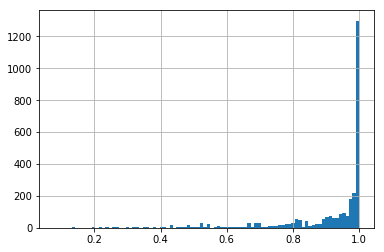

In [6]:
df_account_type['Perc_Months_With_Data'].hist(bins = 90)

In [7]:
df_account_type.head()

,Building_Meter,Months_Total,Months_With_Data,Perc_Months_With_Data
0,1.0 - BLD 01_7836716,103,90,0.873786
1,1.0 - BLD 01_7838586,103,87,0.844660
2,1.0 - BLD 02_7694040,103,90,0.873786
3,1.0 - BLD 03_7177432,103,89,0.864078
4,1.0 - BLD 04_7381828,103,90,0.873786


In [8]:
df_account_type[df_account_type['Months_Total'] == 73][['Perc_Months_With_Data']].describe().loc[['mean', 'std']]

,Perc_Months_With_Data
mean,0.928082
std,0.120928


Focus on accounts that should have data in the most recent 6 years and % of missing months is low.

In [10]:
mask = df_back['Building_Meter'].isin(\
df_account_type[(df_account_type['Months_Total'] == 73) & (df_account_type['Perc_Months_With_Data'] > 0.974068 - 0.047920)].Building_Meter.values)

NameError: name 'df_back' is not defined

There are 941 such accounts in total.

In [ ]:
df = df_back[mask]

In [ ]:
df.Building_Meter.nunique()

In [ ]:
df.head()

In [21]:
df.to_csv("../output/NYCHA_TS.csv")

In [20]:
pwd

'/Users/feiwang/Desktop/capstone/anomalyDetectors/src'

In [19]:
df[df['Building_Meter'] == '10.0 - NA_1864552']

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH


In [ ]:
df_interpolate = df.interpolate(method='time')

In [ ]:
mask = df_interpolate['Building_Meter'] == '1.0 - BLD 01_7836716'
df_interpolate[mask]

## Time Series decomposition

### seasonal_decompose package

Exampe 1 - No gap month

In [ ]:
mask = df.Building_Meter == '165.0 - BLD 03_90327795'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

result = seasonal_decompose(series, model='additive')

series = pd.concat([series, result.trend, result.seasonal, result.resid], axis = 1).reset_index()
series.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Residual']
series['Seasonally_Adjusted'] = series.apply(lambda x: x['Observed'] - x['Seasonal'], axis = 1)

# Meter with all the months' data. Outlier near Sep 2012

result.plot()
pyplot.show()
result1 = result

Example 2 - A few months's gap in between. Otherwise the variations seem normal.

In [ ]:
mask = df.Building_Meter == '164.0 - BLD 01_96973681'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

result = seasonal_decompose(series, model='additive')

series = pd.concat([series, result.trend, result.seasonal, result.resid], axis = 1).reset_index()
series.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Residual']
series['Seasonally_Adjusted'] = series.apply(lambda x: x['Observed'] - x['Seasonal'], axis = 1)

result.plot()
pyplot.show()
result2 = result

Example 3 - Number of months is too small - only 12

In [ ]:
mask = df.Building_Meter == '1.0 - BLD 04_8638820'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')
series.plot()

result = seasonal_decompose(series, model='additive')

series = pd.concat([series, result.trend, result.seasonal, result.resid], axis = 1).reset_index()
series.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Residual']
series['Seasonally_Adjusted'] = series.apply(lambda x: x['Observed'] - x['Seasonal'], axis = 1)

result.plot()
pyplot.show()
result3 = result

### stldecompose package

Exampel 1

In [ ]:
mask = df.Building_Meter == '165.0 - BLD 03_90327795'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

stl1 = decompose(series, period=12)

stl1.plot();

Example 2 - a gaps of 3 months missing data

In [ ]:
mask = df.Building_Meter == '164.0 - BLD 01_96973681'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

stl2 = decompose(series, period=12)

stl2.plot();

Example 3 - Number of months is too small - only 12

In [ ]:
mask = df.Building_Meter == '1.0 - BLD 04_8638820'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

stl3 = decompose(series, period=12)

stl3.plot();

### sesd package

In [ ]:
# R codes

ts = select(filter(df, Building_Meter == '1.0 - BLD 01_7836716'), Month, Imputed_KWH)  
res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=TRUE)  
res$plot 

ts = select(filter(df, Building_Meter == '1.0 - BLD 01_7836716'), Month, Imputed_KWH)  
res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=TRUE)  
res$plot 

In [ ]:
accounts = unique(df$Building_Meter) 

In [ ]:
anoms <- rep(NA, length(accounts))

for (i in seq(1:5))
{
ts = select(filter(df, Building_Meter == account), Month, Imputed_KWH)  
res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=FALSE)  
anoms[i] <- res$anoms 
}

In [ ]:
# Python codes

In [ ]:
import statsmodels.api as sm

Exampel 1

In [ ]:
mask = df.Building_Meter == '165.0 - BLD 03_90327795'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month').Imputed_KWH
ts = series.values.ravel()
outliers_indices = sesd.seasonal_esd(ts, seasonality = 12, hybrid=True, max_anomalies=10)
for idx in outliers_indices:
    print ("Anomaly index: {0}, anomaly value: {1}".format(idx, ts[idx]))

In [ ]:
seasonality = 12
hybrid = True
max_anomalies = 10
alpha = 0.05

ts = np.array(ts)
seasonal = seasonality or int(0.2 * len(ts)) # Seasonality is 20% of the ts if not given.
decomp = sm.tsa.seasonal_decompose(ts, freq=seasonal)
if hybrid:
    mad      = np.median(np.abs(ts - np.median(ts)))
    residual = ts - decomp.seasonal - mad
else:
    residual = ts - decomp.seasonal - np.median(ts)

outliers = sesd.esd(residual, max_anomalies=max_anomalies, alpha=alpha)

seasonal = decomp.seasonal
trend = [np.median(ts) for i in range(len(ts))]
resid = residual
observed = ts

# pd.DataFrame({'observed':ts
#               , 'seasonal':decomp.seasonal
#               , 'median':list([np.median(ts) for i in range(len(ts))])
#               , 'residual':residual
#              })

## Apply G-ESD Test to the residuals

### Example 1

### seasonal_decompose package

In [ ]:
x = result1.resid.Imputed_KWH
x.hist(bins = 100)

In [ ]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 5, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()

### stldecompose package

In [ ]:
x = stl1.resid.Imputed_KWH
x.hist(bins = 100)

In [ ]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 3, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()

### Example 2

### seasonal_decompose package

In [ ]:
x = result2.resid.Imputed_KWH
x.hist(bins = 100)

In [ ]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 5, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()

### stldecompose package

In [ ]:
x = stl2.resid.Imputed_KWH
x.hist(bins = 100)

In [ ]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 3, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()